# Анализ пользовательского поведения в мобильном приложении

## Шаг 1. Общая информация о датафрейме

In [1]:
# импортирую библиотеки
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mth

In [3]:
# вывожу на экран первые 5 строк для ознакомления
display(df.head())

# изучаю информацию о датафрейме
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Изучив полученную информацию можно сказать следующее:**

- Наименования столбцов не соответствуют стилю кода. Необходимо привести их к нижнему регистру и заменить названия столбцов на удобные.
- Данные столбца `EventTimestamp` необходимо преобразовать в нужный тип для работы со временем.
- Пропущенных значений нет.

## Шаг 2. Подготовка данных для дальнейшего анализа

Переименую столбцы и переведу дату в необходимый тип. Также добавлю отдельный столбец дат.

In [4]:
# заменяю наименования столбцов
df = df.rename(columns={'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time', 'ExpId':'group'})

# преобразовываю данные о времени в необходимый для работы тип
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')

# добавлю столбец с датой
df['date'] = df['event_time'].dt.date.astype('datetime64')

Для удобства проведения А/В теста переименую контрольные группы  246 и 247 в `А1` и `A2` соответственно, а экспериментальную группу 248 в `В`.

In [5]:
# обозначила контрольные и экспериментальную группы
df['group'] = df['group'].replace(246, 'A1')
df['group'] = df['group'].replace(247, 'A2')
df['group'] = df['group'].replace(248, 'B')

In [6]:
# проверяю на наличие явных дубликатов
df.duplicated().sum()

413

В данных найдены явные дубликаты и их 413 штук. Приняла решение их удалить.

In [7]:
# удалю явные дубликаты и сброшу индексы
df = df.drop_duplicates().reset_index(drop = True)
df.duplicated().sum()

0

На этапе предобработки данных было выполнено:
- заменены наименования столбцов
- изменены типа данных столбца с датой и временем
- переименованы контрольные и экспериментальная группы
- удалены явные дубликаты
    
После удаления явных дупликатов потери данных составили менее 0,17%. Это допустимо и не должно повлиять на корректность итоговых результатов.

In [8]:
# посмотрим не попадают ли какие-то пользователи в разные группы
df.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

В наших данных нет пользователей, которые попали в разные группы.

## Шаг 3. Изучение и проверка данных

In [9]:
# сколько всего событий в логе
events = df['event_name'].count()
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего 5 вариантов событий: 
- MainScreenAppear - Появление главного экрана
- OffersScreenAppear - Появление предложений на экране
- CartScreenAppear - Появление экрана корзины
- PaymentScreenSuccessful - Экран оплаты
- Tutorial - Руководство пользователя

In [10]:
# сколько всего пользователей в логе
users = df['user_id'].nunique()
users

7551

Всего 7551 уникальных пользователей.

In [11]:
# сколько в среднем событий приходится на пользователя
round(events / users)

32

Примерно 32 события приходится на каждого пользователя.

In [12]:
# посмотрю за какой период данными я располагаю
display(df['date'].min())
df['date'].max()

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

В датафрейме у нас данные за период с 25 июля 2019 по 7 августа 2019 года.

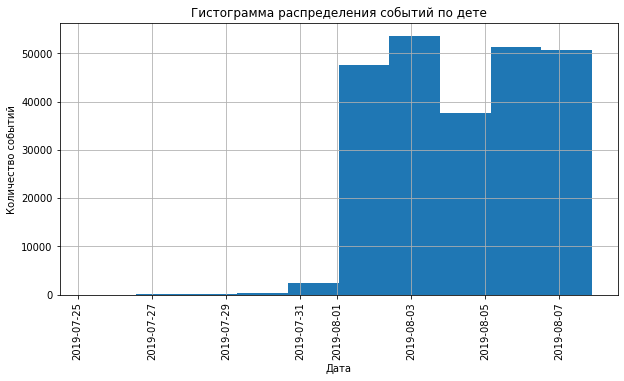

In [13]:
#построю гистограмму по дате
plt.figure(figsize=(10,5))
plt.hist(df['event_time'])
plt.title('Гистограмма распределения событий по дете')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=90)
plt.grid()
plt.show()

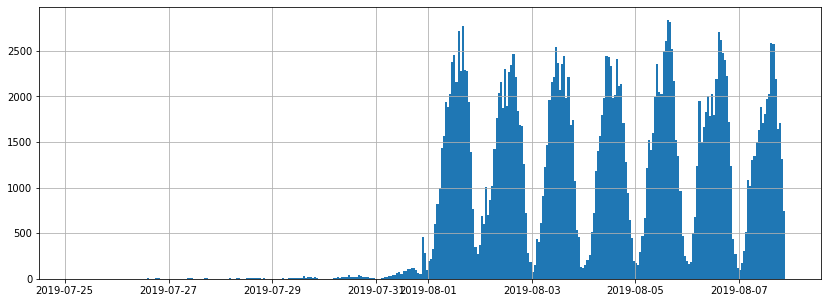

In [14]:
# код ревьюера
df['event_time'].hist(bins=14*24, figsize=(14, 5));

По гистограмее отчетливо видно, что у нас не полные данные. До 1 августа 2019 года их практически нет. Далее следует резкое увеличение активности пользователей в мобильном приложении. Чтобы наши данные не перекасило, для дальнейшего анализа буду использовать период 01.08.2019 - 07.08.2019. Именно за этот период я распологаю полными данными.

In [15]:
# сделаю срез данных за актуальный период
df = df.query('date >= "2019-08-01"').reset_index(drop=True)

In [16]:
# проверю дату начала периода
df['date'].min()

Timestamp('2019-08-01 00:00:00')

Посмотрю, много ли событий и пользователей я потеряла, отбросив старые данные.

In [17]:
# узнаю, сколько пользователей я потеряла
round((users - df['user_id'].nunique()) / users * 100, 2)

0.23

In [18]:
# узнаю, сколько событий я потеряла
round((events - df['event_name'].count()) / events * 100, 2)

1.16

Потеря пользователей составила 0.23%, а потеря событий 1.16%. Это вполне допустимо.

In [19]:
# проверю, что у меня есть пользователи из всех трёх экспериментальных групп
df.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Во всех трех группах почти одинаковое количество пользователей - примерно по 2500.

## Шаг 4. Воронка событий

In [20]:
# посмотрю, какие события есть в логах, как часто они встречаются. Отсортирую события по частоте.
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

- MainScreenAppear - Появление главного экрана
- OffersScreenAppear - Появление предложений на экране
- CartScreenAppear - Появление экрана корзины
- PaymentScreenSuccessful - Экран оплаты
- Tutorial - Руководство пользователя

In [21]:
# посчитайю, сколько пользователей совершали каждое из этих событий
pro_users = df.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
pro_users['all'] = df['user_id'].nunique()
# посчитаю долю пользователей, которые хоть раз совершали событие.
pro_users['percent'] = ((pro_users['user_id'] / pro_users['all'])*100).round(2)
pro_users

,event_name,user_id,all,percent
0,MainScreenAppear,7419,7534,98.47
1,OffersScreenAppear,4593,7534,60.96
2,CartScreenAppear,3734,7534,49.56
3,PaymentScreenSuccessful,3539,7534,46.97
4,Tutorial,840,7534,11.15


Предположу, в каком порядке происходят события. 
В начеле появляется главный экран `MainScreenAppear`, затем пользователь изучает предложения `OffersScreenAppear`, переходит в корзину `CartScreenAppear` и оплачивает `PaymentScreenSuccessful`. Но последнее событие `Tutorial - Руководство пользователя` не встраивается в последовательную цепочку при расчете воронки. Это событие не будем учитывать.
    
Также стоит отметить, что почти 40% пользователей мы теряем сразу после просмотра главного экрана, а до оплаты доходят только примернро 47%.

In [22]:
# удаляю событие из датафрейма
df=df[df['event_name'] != 'Tutorial']

По воронке событий посчитаю, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 

In [23]:
for i in pro_users.index:
    if i == 0:
        pro_users.loc[i, 'funnel'] = 100
    else:
        pro_users.loc[i, 'funnel'] = (pro_users.loc[i, 'user_id'] /
                                       pro_users.loc[i-1, 'user_id'] * 100)
pro_users[pro_users['event_name'] != 'Tutorial']

,event_name,user_id,all,percent,funnel
0,MainScreenAppear,7419,7534,98.47,100.000000
1,OffersScreenAppear,4593,7534,60.96,61.908613
2,CartScreenAppear,3734,7534,49.56,81.297627
3,PaymentScreenSuccessful,3539,7534,46.97,94.777718


По воронке событий также отмечаю отток пользователей после просмотра главной страницы. Мы теряем почти 38%. Это достаточно много. Можно предположить, что интерфейс главной страницы неудобен или непонятен для некоторых пользователей. Как вариант - возможно приложение некорректо работает на определенных устройствах. 
    
Если пользователь попал на страницу предложений, то в 81% случаях он переходит в корзину. И оплачивают заказ почти в 95%. Это очень хорошие показатели.
    
Также стоит отметить, что примерно 47% пользователей доходит от первого события до оплаты.

## Шаг 5. Результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [25]:
# найду количество пользователей в каждой экспериментальной группе
users = df.groupby('group')['user_id'].nunique().reset_index()
users

,group,user_id
0,A1,2483
1,A2,2512
2,B,2535


В контрольной группе `А2` и экспериментальной группе `В` почти одинаковое количество пользователей - 2512 и 2535 соответственно. Однако в контрольной группе `А1` пользователей меньше.

### Выберу самое популярное событие. Посчитаю число пользователей, совершивших это событие в каждой из контрольных групп и долю пользователей, совершивших это событие. Проверю, будет ли отличие между группами статистически достоверным. 

In [26]:
# найду самое популярное событие
pro_users[['event_name','user_id']]

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Самым популярным событием явлется `MainScreenAppear` - показ основного экрана.

In [27]:
# посчитаю число пользователей, совершивших это событие в каждой из контрольных групп
# и долю пользователей, совершивших это событие
# для удобства выводы информаци напишу функцию

def event_users_in_group (event):
    data = df[df['event_name'] == event].groupby('group').agg({'user_id': 'nunique'})
    data.columns = ['users_event']
    data['users_group'] = df.groupby('group').agg({'user_id': 'nunique'})
    # добавлю строку с двумя объединенными контрольными группами     
    data.loc['A1+A2', 'users_event'] = data.loc['A1', 'users_event'] + data.loc['A2', 'users_event']
    data.loc['A1+A2', 'users_group'] = data.loc['A1', 'users_group'] + data.loc['A2', 'users_group']
    data['percent'] = ((data['users_event'] / data['users_group']) * 100).round(2)
    return data

In [28]:
msa_users = event_users_in_group ('MainScreenAppear')
msa_users.query('group != ["B", "A1+A2"]')

,users_event,users_group,percent
group,,,
A1,2450.0,2483.0,98.67
A2,2476.0,2512.0,98.57


Сформулирую гипотезы:

- H0: "Разница между долями участвующих в событии пользователей в группах А1 и А2 статистически незначима".
- H1: "Разница между долями участвующих в событии пользователей в группах А1 и А2 статистически значима".

In [29]:
# также напишу функцию для расчета Z-критерия
def z_test (results, group_1, group_2):
    # пропорция успехов в первой группе:
    p1 = results.loc[group_1,'users_event']/results.loc[group_1,'users_group']
    # пропорция успехов во второй группе:
    p2 = results.loc[group_2,'users_event']/results.loc[group_2,'users_group']
    # пропорция успехов в комбинированном датасете:
    p_combined = ((results.loc[group_1,'users_event'] + results.loc[group_2,'users_event']) / 
              (results.loc[group_1,'users_group'] + results.loc[group_2,'users_group']))
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаю статистику в ст.отклонениях стандартного нормального распределения
    z_value = (difference / mth.sqrt(p_combined * (1 - p_combined) * (1/results.loc[group_1,'users_group'] 
                                                                 + 1/results.loc[group_2,'users_group'])))
    # задаю стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [30]:
alpha = 0.01
z_test (msa_users, 'A1', 'A2')

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей показала, что мы не можем отвергнуть нулевую гипотезу (разница между долями участвующих в событии пользователей в группах А1 и А2 статистически незначима), нет оснований считать доли разными.

### Проделаю то же самое для всех других событий.

Сформулирую гипотезы для всех событий:

- H0: "Разница между долями участвующих в событии пользователей в группах А1 и А2 статистически незначима".
- H1: "Разница между долями участвующих в событии пользователей в группах А1 и А2 статистически значима".

#### OffersScreenAppear

In [31]:
# посчитаю число пользователей, совершивших это событие в каждой из контрольных групп
# и долю пользователей, совершивших это событие
osa_users = event_users_in_group ('OffersScreenAppear')
display(osa_users.query('group != ["B", "A1+A2"]'))

# провезу z тест для события
z_test (osa_users, 'A1', 'A2')

,users_event,users_group,percent
group,,,
A1,1542.0,2483.0,62.10
A2,1520.0,2512.0,60.51


p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### CartScreenAppear

In [32]:
# посчитаю число пользователей, совершивших это событие в каждой из контрольных групп
# и долю пользователей, совершивших это событие
csa_users = event_users_in_group ('CartScreenAppear')
display(csa_users.query('group != ["B", "A1+A2"]'))

# провезу z тест для события
z_test (csa_users, 'A1', 'A2')

,users_event,users_group,percent
group,,,
A1,1266.0,2483.0,50.99
A2,1238.0,2512.0,49.28


p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### PaymentScreenSuccessful

In [33]:
# посчитаю число пользователей, совершивших это событие в каждой из контрольных групп
# и долю пользователей, совершивших это событие
pss_users = event_users_in_group ('PaymentScreenSuccessful')
display(pss_users.query('group != ["B", "A1+A2"]'))

# провезу z тест для события
z_test (pss_users, 'A1', 'A2')

,users_event,users_group,percent
group,,,
A1,1200.0,2483.0,48.33
A2,1158.0,2512.0,46.10


p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Провела проверку гипотез для каждого события на статистическую значимость разницы между долями участвующих в событии пользователей в группах А1 и А2. Ни на одном этапе проверок не удалось отвергнуть гипотезу о равных долях. 
    
**Итоговый вывод** - нет оснований считать, что разбиение на группы работает некорректно и мы можем быть уверены в точности проведенного тестирования.

### Аналогично поступлю с группой с изменённым шрифтом. Сравню результаты с каждой из контрольных групп в отдельности по каждому событию. Также сравню результаты с объединённой контрольной группой.

Используя ранее написанную функцию `event_users_in_group` посчитаю число пользователей, совершивших каждое событие в каждой из контрольных групп и долю пользователей, совершивших это событие. 

In [34]:
msa_results = event_users_in_group('MainScreenAppear')
msa_results

,users_event,users_group,percent
group,,,
A1,2450.0,2483.0,98.67
A2,2476.0,2512.0,98.57
B,2493.0,2535.0,98.34
A1+A2,4926.0,4995.0,98.62


In [35]:
osa_results = event_users_in_group('OffersScreenAppear')
osa_results

,users_event,users_group,percent
group,,,
A1,1542.0,2483.0,62.10
A2,1520.0,2512.0,60.51
B,1531.0,2535.0,60.39
A1+A2,3062.0,4995.0,61.30


In [36]:
csa_results = event_users_in_group('CartScreenAppear')
csa_results

,users_event,users_group,percent
group,,,
A1,1266.0,2483.0,50.99
A2,1238.0,2512.0,49.28
B,1230.0,2535.0,48.52
A1+A2,2504.0,4995.0,50.13


In [37]:
pss_results = event_users_in_group('PaymentScreenSuccessful')
pss_results

,users_event,users_group,percent
group,,,
A1,1200.0,2483.0,48.33
A2,1158.0,2512.0,46.10
B,1181.0,2535.0,46.59
A1+A2,2358.0,4995.0,47.21


Проведу проверку гипотез о статистической значимости разницы между контрольными и экспериментальной группами с помощью функции `z_test`.
    
Сформулирую гипотезы для всех событий и групп:

- H0: "Разница между долями участвующих в событии пользователей в группах статистически незначима".
- H1: "Разница между долями участвующих в событии пользователей в группах статистически значима".

In [38]:
# сравнение контрольной группы А1 и экспериментальной группы В
print('Проверка стат. значимости по событию MainScreenAppear в группах А1 и В')
z_test(msa_results,'A1','B')
print('')
print('Проверка стат. значимости по событию OffersScreenAppear в группах А1 и В')
z_test(osa_results,'A1','B')
print('')
print('Проверка стат. значимости по событию CartScreenAppear в группах А1 и В')
z_test(csa_results,'A1','B')
print('')
print('Проверка стат. значимости по событию PaymentScreenSuccessful в группах А1 и В')
z_test(pss_results,'A1','B')

Проверка стат. значимости по событию MainScreenAppear в группах А1 и В
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию OffersScreenAppear в группах А1 и В
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию CartScreenAppear в группах А1 и В
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию PaymentScreenSuccessful в группах А1 и В
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
# сравнение контрольной группы А2 и экспериментальной группы В
print('Проверка стат. значимости по событию MainScreenAppear в группах А2 и В')
z_test(msa_results,'A2','B')
print('')
print('Проверка стат. значимости по событию OffersScreenAppear в группах А2 и В')
z_test(osa_results,'A2','B')
print('')
print('Проверка стат. значимости по событию CartScreenAppear в группах А2 и В')
z_test(csa_results,'A2','B')
print('')
print('Проверка стат. значимости по событию PaymentScreenSuccessful в группах А2 и В')
z_test(pss_results,'A2','B')

Проверка стат. значимости по событию MainScreenAppear в группах А2 и В
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию OffersScreenAppear в группах А2 и В
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию CartScreenAppear в группах А2 и В
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию PaymentScreenSuccessful в группах А2 и В
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [40]:
# сравнение объединенной контрольной группы А1+А2 и экспериментальной группы В

print('Проверка стат. значимости по событию MainScreenAppear в группах А1+А2 и В')
z_test(msa_results,'A1+A2','B')
print('')
print('Проверка стат. значимости по событию OffersScreenAppear в группах А1+А2 и В')
z_test(osa_results,'A1+A2','B')
print('')
print('Проверка стат. значимости по событию CartScreenAppear в группах А1+А2 и В')
z_test(csa_results,'A1+A2','B')
print('')
print('Проверка стат. значимости по событию PaymentScreenSuccessful в группах А1+А2 и В')
z_test(pss_results,'A1+A2','B')

Проверка стат. значимости по событию MainScreenAppear в группах А1+А2 и В
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию OffersScreenAppear в группах А1+А2 и В
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию CartScreenAppear в группах А1+А2 и В
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимости по событию PaymentScreenSuccessful в группах А1+А2 и В
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Провела 16 проверок гипотез для каждого события на статистическую значимость разницы между долями участвующих в событии пользователей в группах А1, А2, В и объединенной группы А1+А2. Ни на одном этапе проверок не удалось отвергнуть гипотезу о равных долях. 
    
**Итоговый вывод** - нет оснований считать, что разбиение на группы работает некорректно и мы можем быть уверены в точности проведенного тестирования.

Уровень значимости при проверке статистических гипотез выше я выбрала `alpha = 0.01` 
При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Поэтому такой уровень значимости применять не стоит.

При проверке статестических гипотез как правило устанавливают уровень значимости 0.05 или 0.01. В нашем случае предстоит выполнить 16 проверок и так как тест множественный, то с каждой новой проверкой растет вероятность ошибки первого рода - ложнопозитивным результатом статистического теста. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют поправку Бонферрони. Для этого уровень значимоти необходимо поделить на количество тестов. в тшем случае `0.01/16 = 0.000625`. Такой уровень значимости сильно уменьшит мощность теста. А при проверке гипотез не получили позитивных результатов, значит получение ложнопозитивного результата исключено.

# Общий вывод

В результате проведенного исследования можно сделать следующие выводы:

- При проведении исследовательского анализа и по гистограмме распреденления событий по дате, отчетливо видно, что у нас не полные данные. До 1 августа 2019 года их практически нет. Далее следует резкое увеличение активности пользователей в мобильном приложении. Чтобы наши данные не перекасило, для дальнейшего анализа буду использовать период 01.08.2019 - 07.08.2019. Именно за этот период я распологаю полными данными.
- Также были выявлены явные дубликаты. 
- После удаления явных дубликатов потеря данных составила менее 0.17%. А при отсекании даты - потеря пользователей составила 0.23%, а потеря событий 1.16%. Это допустимо и не должно повлиять на корректность итоговых результатов.
- В логах у нас всего 5 вариантов событий:
* `MainScreenAppear` - Появление главного экрана
* `OffersScreenAppear` - Появление предложений на экране
* `CartScreenAppear` - Появление экрана корзины
* `PaymentScreenSuccessful` - Экран оплаты
* `Tutorial` - Руководство пользователя
- Предположу, что воронка событий выглядит таким образом. В начеле появляется главный экран `MainScreenAppear`, затем пользователь изучает предложения `OffersScreenAppear`, переходит в корзину `CartScreenAppear` и оплачивает `PaymentScreenSuccessful`. Но последнее событие `Tutorial` - Руководство пользователя не встраивается в последовательную цепочку при расчете воронки. Это событие не будем учитывать.
- По воронке событий отмечаю отток пользователей после просмотра главной страницы. Мы теряем почти 38%. Это достаточно много. Можно предположить, что интерфейс главной страницы неудобен или непонятен для некоторых пользователей. Как вариант - возможно приложение некорректо работает на определенных устройствах.
- Если пользователь попал на страницу предложений, то в 81% случаях он переходит в корзину. И оплачивают заказ почти в 95%. Это очень хорошие показатели.
- Также стоит отметить, что примерно 47% пользователей доходит от первого события до оплаты.
- В контрольной группе А2 и экспериментальной группе В почти одинаковое количество пользователей - 2512 и 2535 соответственно. Однако в контрольной группе А1 пользователей меньше. Необходимо проверить есть ли статестическая разница между выборками групп А1 и А2. Для этого сформулирую гипотезы:
* Нулевая H0: пропорций пользователей у контрольных групп A1 и A2 одинаковые.
* Альтернативная H1: пропорций пользователей у контрольных групп А1 и А2 разные.
- Проверка гипотезы о равенстве долей показала, что мы не можем отвергнуть нулевую гипотезу (пропорций пользователей у контрольных групп A1 и A2 одинаковые), нет оснований считать доли разными. Раз статистика не находит разницу между контрольными группами, значит распределение пользователей произведено корректно.
- Провела 16 проверок гипотез для каждого события на статистическую значимость разницы между долями участвующих в событии пользователей в группах А1, А2, В и объединенной группы А1+А2. Ни на одном этапе проверок не удалось отвергнуть гипотезу о равных долях.

**Итоговый вывод - нет оснований считать, что разбиение на группы работает некорректно и мы можем быть уверены в точности проведенного тестирования.** 
    
**И самое главное - изменение шрифта в приложении не повлияло на поведение пользователей мобильного приложения.**
    
**Рекомендация: 38% пользователей мы теряем на этапе просмотра главного экрана. Можно предположить, что интерфейс главной страницы неудобен или непонятен для некоторых пользователей. Как вариант - возможно приложение некорректо работает на определенных устройствах. Необходимо подумать над этим вопросом**